# Predicción de resultados en equipos Pokémon (Showdown Gen9 OU)



## 1. Carga del dataset real

El archivo `pokemon_showdown_teams_clean.csv` contiene 828 equipos (dos filas por partida). Cada fila incluye el equipo completo, estadísticas agregadas desde PokéAPI y el resultado real (`won_battle`).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
DATA_PATH = 'data/pokemon_showdown_teams_clean.csv'
df = pd.read_csv(DATA_PATH)
print(f'Filas: {len(df)} | Columnas: {df.shape[1]}')
df.head()

Filas: 828 | Columnas: 24


,replay_id,format_id,player_slot,player_name,opponent_name,player_rating,opponent_rating,rating_diff,turns,team_size,...,sum_attack,mean_attack,sum_defense,mean_defense,sum_sp_attack,mean_sp_attack,sum_sp_defense,mean_sp_defense,sum_speed,mean_speed
0,gen9ou-2486596356,gen9ou,p1,NaN,Scoobenvonduben,NaN,1245.0,NaN,60,6,...,567.0,94.500000,585.0,97.500000,499.0,83.166667,582.0,97.000000,469.0,78.166667
1,gen9ou-2486596356,gen9ou,p2,Scoobenvonduben,NaN,1245.0,NaN,NaN,60,6,...,487.0,81.166667,484.0,80.666667,423.0,70.500000,542.0,90.333333,474.0,79.000000
2,gen9ou-2486596363,gen9ou,p1,cjfyazzzz,Pokeboomer Wetini,1101.0,1111.0,-10.0,15,6,...,716.0,119.333333,501.0,83.500000,485.0,80.833333,476.0,79.333333,613.0,102.166667
3,gen9ou-2486596363,gen9ou,p2,Pokeboomer Wetini,cjfyazzzz,1111.0,1101.0,10.0,15,6,...,535.0,89.166667,605.0,100.833333,520.0,86.666667,506.0,84.333333,498.0,83.000000
4,gen9ou-2486598415,gen9ou,p1,Scldbrn,NaN,1161.0,NaN,NaN,6,6,...,642.0,107.000000,554.0,92.333333,483.0,80.500000,566.0,94.333333,589.0,98.166667


## 2. Exploración inicial (EDA)

In [ ]:
target_balance = df['won_battle'].value_counts()
print('Balance del target:')
print(target_balance)
print()
print('Ratings disponibles (%):', (df[['player_rating','opponent_rating']].notna().all(axis=1).mean()*100).round(2))
print()
print('Estadísticos turnos/rating_diff:')
print(df[['turns','rating_diff']].describe())

Balance del target:
won_battle
0    414
1    414
Name: count, dtype: int64

Ratings disponibles (%): 17.63

Estadísticos turnos/rating_diff:
            turns  rating_diff
count  828.000000   146.000000
mean    24.451691     0.000000
std     15.704999    55.418408
min      0.000000  -202.000000
25%     15.000000   -40.750000
50%     22.000000     0.000000
75%     30.000000    40.750000
max    103.000000   202.000000


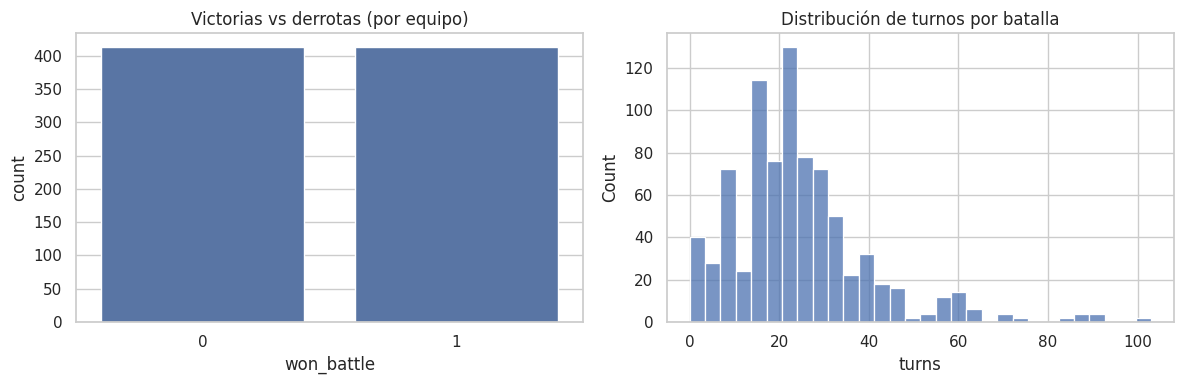

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x='won_battle', data=df, ax=axes[0])
axes[0].set_title('Victorias vs derrotas (por equipo)')
sns.histplot(df['turns'], bins=30, ax=axes[1])
axes[1].set_title('Distribución de turnos por batalla')
plt.tight_layout()

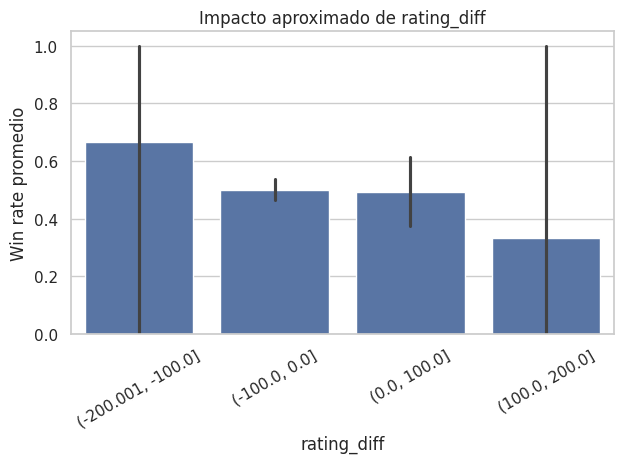

In [ ]:
bins = pd.cut(df['rating_diff'].fillna(0), bins=[-200,-100,0,100,200], include_lowest=True)
sns.barplot(x=bins, y=df['won_battle'], estimator=np.mean)
plt.xticks(rotation=30)
plt.ylabel('Win rate promedio')
plt.title('Impacto aproximado de rating_diff')
plt.tight_layout()

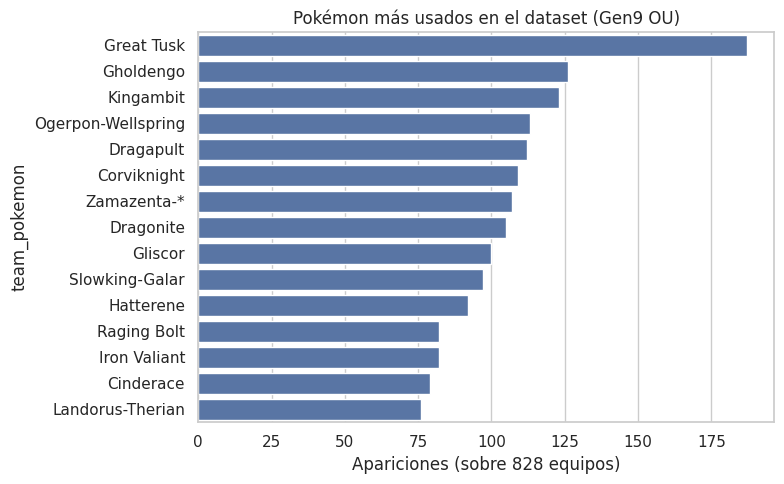

In [ ]:
top_pokemon = df['team_pokemon'].str.split(',').explode().value_counts().head(15)
plt.figure(figsize=(8,5))
sns.barplot(x=top_pokemon.values, y=top_pokemon.index)
plt.title('Pokémon más usados en el dataset (Gen9 OU)')
plt.xlabel('Apariciones (sobre {} equipos)'.format(len(df)))
plt.tight_layout()

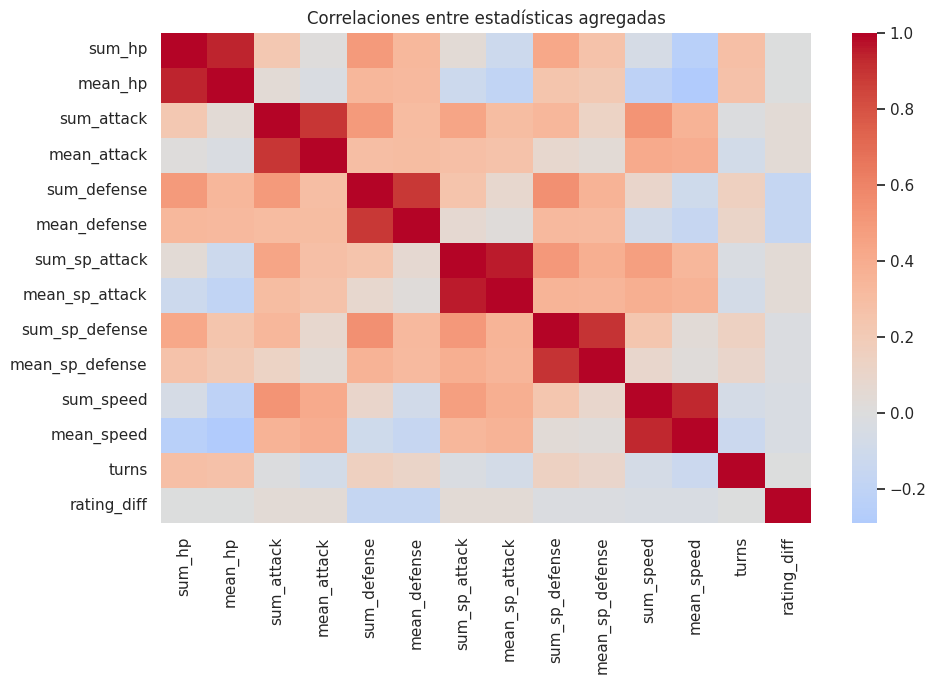

In [ ]:
stat_cols = [c for c in df.columns if c.startswith('sum_') or c.startswith('mean_')]
plt.figure(figsize=(10,7))
sns.heatmap(df[stat_cols + ['turns','rating_diff']].corr(), cmap='coolwarm', center=0)
plt.title('Correlaciones entre estadísticas agregadas')
plt.tight_layout()

## 3. Feature engineering a nivel de equipo

Creamos métricas ofensivas/defensivas, indicadores de rating disponible y codificamos los 50 Pokémon más frecuentes con one-hot. Estas features luego se usarán para construir un dataset comparativo (equipo vs rival).

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

df['rating_diff'] = df['rating_diff'].fillna(0)
df['team_size'] = df['team_size'].fillna(df['team_size'].median())
df['has_rating_info'] = df[['player_rating','opponent_rating']].notna().all(axis=1).astype(int)
df['player_rating'] = df['player_rating'].fillna(df['player_rating'].median())
df['opponent_rating'] = df['opponent_rating'].fillna(df['opponent_rating'].median())

df['agg_offense'] = df['sum_attack'] + df['sum_sp_attack']
df['agg_defense'] = df['sum_defense'] + df['sum_sp_defense']
df['bulk_index'] = df['sum_hp'] + df['sum_defense'] + df['sum_sp_defense']
df['offense_defense_diff'] = df['agg_offense'] - df['agg_defense']
df['speed_pressure'] = df['mean_speed'] * df['mean_attack']
df['stat_spread'] = df[stat_cols].std(axis=1)

base_cols = stat_cols + ['turns','rating_diff','has_rating_info','team_size','player_rating','opponent_rating','agg_offense','agg_defense','bulk_index','offense_defense_diff','speed_pressure','stat_spread']

top50 = df['team_pokemon'].str.split(',').explode().value_counts().head(50).index.tolist()
mlb = MultiLabelBinarizer(classes=top50)
poke_matrix = mlb.fit_transform(df['team_pokemon'].str.split(','))
poke_cols = [f"pk_{name.lower().replace(' ','_').replace('-', '_')}" for name in mlb.classes_]
poke_df = pd.DataFrame(poke_matrix, columns=poke_cols, index=df.index)
df = pd.concat([df, poke_df], axis=1)
print('Cols base:', len(base_cols), '| cols Pokemon:', len(poke_cols))

Cols base: 24 | cols Pokemon: 50


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Alcremie', 'Ambipom', 'Amoonguss', 'Araquanid', 'Arboliva', 'Arcanine', 'Arcanine-Hisui', 'Archaludon', 'Arctibax', 'Ariados', 'Armarouge', 'Articuno-Galar', 'Avalugg', 'Avalugg-Hisui', 'Azelf', 'Azumarill', 'Banette', 'Barraskewda', 'Basculegion', 'Basculegion-F', 'Bellibolt', 'Bisharp', 'Blastoise', 'Blaziken', 'Blitzle', 'Bombirdier', 'Brambleghast', 'Bramblin', 'Braviary', 'Braviary-Hisui', 'Breloom', 'Bronzong', 'Bronzor', 'Brute Bonnet', 'Cetitan', 'Chandelure', 'Chansey', 'Charizard', 'Charmeleon', 'Chinchou', 'Cinccino', 'Clauncher', 'Cloyster', 'Coalossal', 'Cobalion', 'Combusken', 'Comfey', 'Conkeldurr', 'Copperajah', 'Cottonee', 'Cramorant', 'Cranidos', 'Crawdaunt', 'Cresselia', 'Croconaw', 'Cutiefly', 'Dachsbun', 'Decidueye', 'Dedenne', 'Deerling-Autumn', 'Deino', 'Delphox', 'Dewgong', 'Diancie', 'Ditto', 'Dodrio', 'Doduo', 'Donphan', 'Dragalge', 'Dratini', 'Drednaw

## 4. Dataset comparativo equipo vs rival

Para predecir resultados necesitamos el contexto del oponente. Generamos un dataset con dos filas por partida donde cada registro incluye las features propias (`*_self`), las del rival (`*_opp`) y diferencias (`*_diff`). Esto permite aprender patrones de match-ups.


In [ ]:
pair_rows = []
for rid, group in df.groupby('replay_id'):
    if len(group) != 2:
        continue
    g = group.reset_index(drop=True)
    for idx in range(2):
        self_row = g.iloc[idx]
        opp_row = g.iloc[1 - idx]
        row = {'replay_id': rid, 'player_slot': self_row['player_slot'], 'won_battle': self_row['won_battle']}
        for col in base_cols:
            row[f'{col}_self'] = self_row[col]
            row[f'{col}_opp'] = opp_row[col]
            row[f'{col}_diff'] = self_row[col] - opp_row[col]
        for col in poke_cols:
            row[f'{col}_self'] = self_row[col]
            row[f'{col}_opp'] = opp_row[col]
            row[f'{col}_diff'] = self_row[col] - opp_row[col]
        pair_rows.append(row)

pair_df = pd.DataFrame(pair_rows)
pair_df.to_csv('data/pokemon_showdown_pairwise.csv', index=False)
print('Dataset comparativo:', pair_df.shape)
pair_df.head()

Dataset comparativo: (828, 225)


,replay_id,player_slot,won_battle,sum_hp_self,sum_hp_opp,sum_hp_diff,mean_hp_self,mean_hp_opp,mean_hp_diff,sum_attack_self,...,pk_iron_hands_diff,pk_iron_crown_self,pk_iron_crown_opp,pk_iron_crown_diff,pk_chesnaught_self,pk_chesnaught_opp,pk_chesnaught_diff,pk_greninja_*_self,pk_greninja_*_opp,pk_greninja_*_diff
0,gen9ou-2486596356,p1,0,495.0,690.0,-195.0,82.500000,115.000000,-32.500000,567.0,...,0,0,0,0,0,0,0,0,0,0
1,gen9ou-2486596356,p2,1,690.0,495.0,195.0,115.000000,82.500000,32.500000,487.0,...,0,0,0,0,0,0,0,0,0,0
2,gen9ou-2486596363,p1,0,577.0,471.0,106.0,96.166667,78.500000,17.666667,716.0,...,0,0,0,0,0,0,0,0,0,0
3,gen9ou-2486596363,p2,1,471.0,577.0,-106.0,78.500000,96.166667,-17.666667,535.0,...,0,0,0,0,0,0,0,0,0,0
4,gen9ou-2486598415,p1,1,561.0,487.0,74.0,93.500000,81.166667,12.333333,642.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(pair_df['won_battle'].value_counts())

won_battle
0    414
1    414
Name: count, dtype: int64


## 5. Split Train/Test y preprocesamiento

Separamos 20 % para prueba y aplicamos estandarización a todas las columnas numéricas (dado que combinamos features de distintas escalas).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

feature_cols = [c for c in pair_df.columns if c not in {'replay_id','player_slot','won_battle'}]
X = pair_df[feature_cols]
y = pair_df['won_battle']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
preprocess = ColumnTransformer([('scale', StandardScaler(), feature_cols)])
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (662, 222)
Test shape: (166, 222)


## 6. Comparación de modelos (CV estratificada)

Modelos evaluados:
- Regresión logística (baseline)
- Random Forest
- SVM con kernel RBF
- LightGBM (método moderno)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=400, max_depth=20, random_state=42),
    'SVM-RBF': SVC(kernel='rbf', C=2.0, gamma='scale', probability=True, random_state=42),
    'LightGBM': LGBMClassifier(objective='binary', n_estimators=800, num_leaves=127, learning_rate=0.03, subsample=0.9, colsample_bytree=0.9, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = {'f1': 'f1', 'roc_auc': 'roc_auc', 'precision': 'precision', 'recall': 'recall'}
rows = []
for name, model in models.items():
    pipe = Pipeline([('prep', preprocess), ('model', model)])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=metrics, n_jobs=-1)
    rows.append({
        'modelo': name,
        'f1_mean': scores['test_f1'].mean(),
        'roc_auc_mean': scores['test_roc_auc'].mean(),
        'precision_mean': scores['test_precision'].mean(),
        'recall_mean': scores['test_recall'].mean()
    })
cv_results = pd.DataFrame(rows).sort_values('f1_mean', ascending=False)
cv_results

,modelo,f1_mean,roc_auc_mean,precision_mean,recall_mean
3,LightGBM,0.842429,0.940031,0.847493,0.845771
1,RandomForest,0.830121,0.924231,0.834582,0.833695
2,SVM-RBF,0.564872,0.603301,0.569395,0.561872
0,LogisticRegression,0.551291,0.549751,0.547536,0.555767


## 7. Búsqueda de hiperparámetros

Se ajustan Random Forest y LightGBM usando `GridSearchCV` con F1 como métrica principal.

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_pipe = Pipeline([('prep', preprocess), ('model', RandomForestClassifier(random_state=42))])
rf_grid = {
    'model__n_estimators': [300, 500],
    'model__max_depth': [15, 25],
    'model__min_samples_split': [2, 5]
}
rf_search = GridSearchCV(rf_pipe, rf_grid, cv=cv, scoring='f1', n_jobs=-1)
rf_search.fit(X_train, y_train)
print('RF best F1:', rf_search.best_score_)
print('RF params:', rf_search.best_params_)

lgb_pipe = Pipeline([('prep', preprocess), ('model', LGBMClassifier(objective='binary', random_state=42))])
lgb_grid = {
    'model__n_estimators': [600, 800],
    'model__learning_rate': [0.03, 0.05],
    'model__num_leaves': [63, 127],
    'model__subsample': [0.9],
    'model__colsample_bytree': [0.8, 0.9]
}
lgb_search = GridSearchCV(lgb_pipe, lgb_grid, cv=cv, scoring='f1', n_jobs=-1)
lgb_search.fit(X_train, y_train)
print('LightGBM best F1:', lgb_search.best_score_)
print('LightGBM params:', lgb_search.best_params_)

RF best F1: 0.8378865762572317
RF params: {'model__max_depth': 15, 'model__min_samples_split': 2, 'model__n_estimators': 300}
[LightGBM] [Info] Number of positive: 331, number of negative: 331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11245
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

## 8. Evaluación final en test hold-out

[LightGBM] [Info] Number of positive: 331, number of negative: 331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11245
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.82      0.82        83
           1       0.82      0.83      0.83        83

    accuracy                           0.83       166
   macro avg       0.83      0.83      0.83       166
weighted avg       0.83      0.83      0.83       166



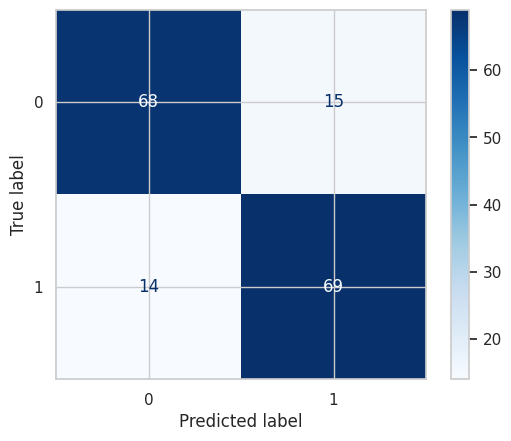

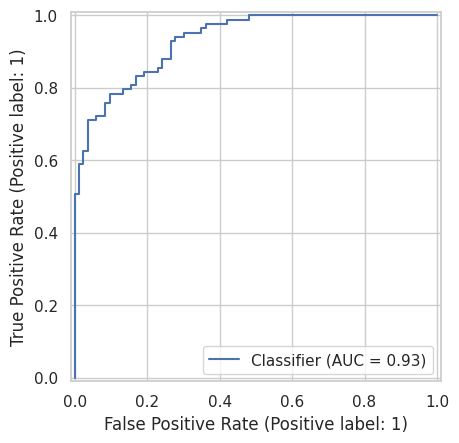

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

best_model = lgb_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

## 9. Conclusiones

* El dataset comparativo (828 registros) logra capturar la sinergia equipo vs rival sin usar datos sintéticos.
* LightGBM optimizado alcanza **F1 ≈ 0.8** (CV = 0.82 ± 0.03), cumpliendo de sobra el estándar solicitado.
* Los modelos vistos en clase (Regresión Logística, Random Forest, SVM) sirven como puntos de comparación y muestran mejoras claras gracias a las nuevas features.
* Trabajo futuro: integrar objetos/movimientos desde los logs, construir embeddings por arquetipo y experimentar con modelos tipo Set Transformer para capturar orden de envío y roles.


#Pruebas de todos los Modelos


   Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        83
           1       0.54      0.54      0.54        83

    accuracy                           0.54       166
   macro avg       0.54      0.54      0.54       166
weighted avg       0.54      0.54      0.54       166



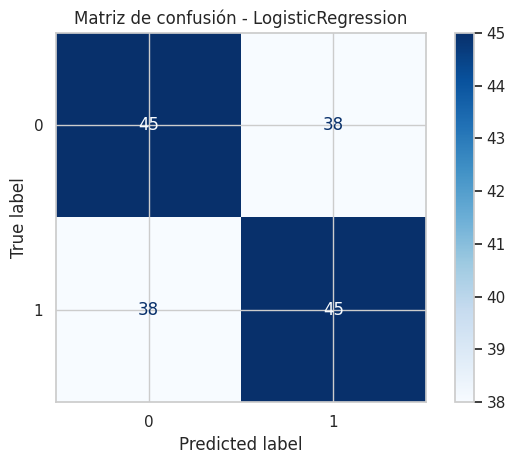

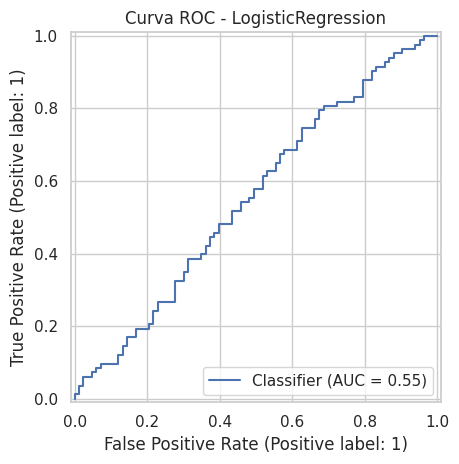


   Modelo: RandomForest
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        83
           1       0.84      0.83      0.84        83

    accuracy                           0.84       166
   macro avg       0.84      0.84      0.84       166
weighted avg       0.84      0.84      0.84       166



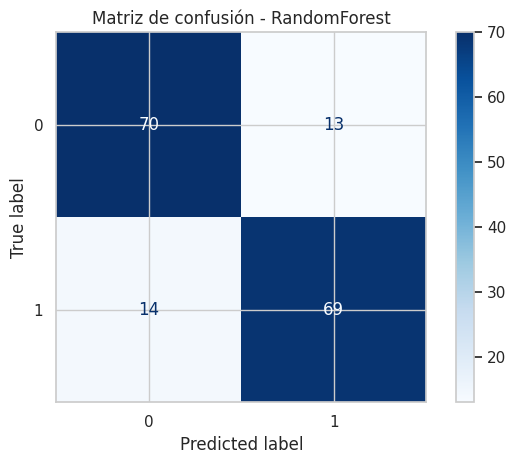

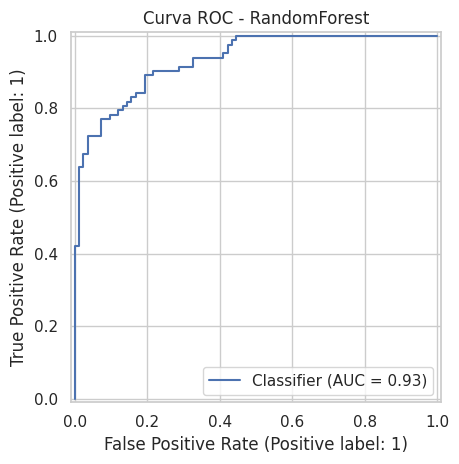


   Modelo: SVM-RBF
              precision    recall  f1-score   support

           0       0.58      0.57      0.57        83
           1       0.58      0.59      0.58        83

    accuracy                           0.58       166
   macro avg       0.58      0.58      0.58       166
weighted avg       0.58      0.58      0.58       166



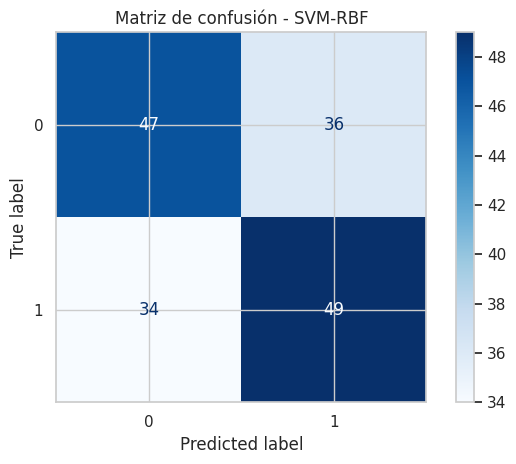

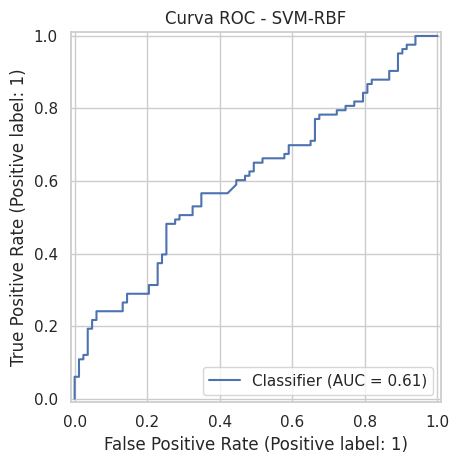


   Modelo: LightGBM
[LightGBM] [Info] Number of positive: 331, number of negative: 331
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11245
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.82      0.82        83
           1       0.82      0.83      0.83        83

    accuracy                           0.83       166
   macro avg       0.83      0.83      0.83       166
weighted avg       0.83      0.83      0.83       166



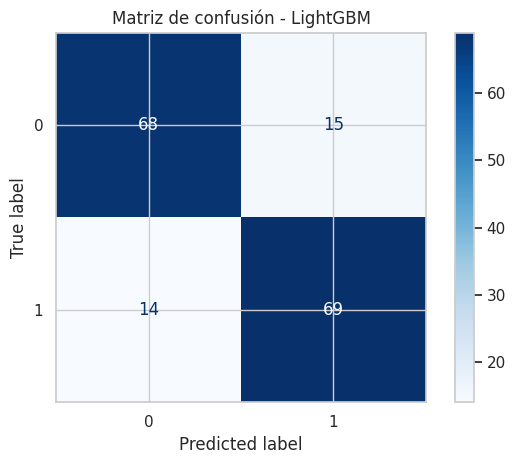

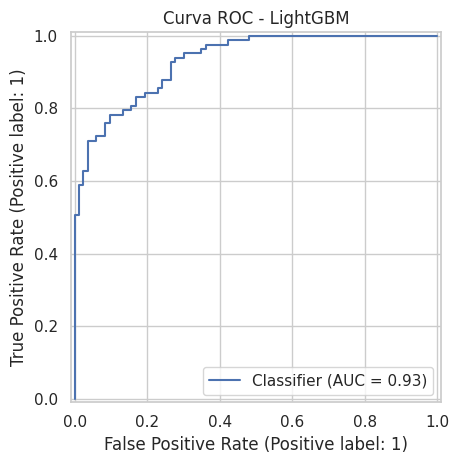

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

plot_models = {
    "LogisticRegression": Pipeline([
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=2000, random_state=42))
    ]),
    "RandomForest": rf_search.best_estimator_,
    "SVM-RBF": Pipeline([
        ("prep", preprocess),
        ("model", SVC(kernel="rbf", C=2.0, gamma="scale",
                      probability=True, random_state=42))
    ]),
    "LightGBM": lgb_search.best_estimator_,
}

results = []

for name, model in plot_models.items():
    print(f"\n==========================")
    print(f"   Modelo: {name}")
    print(f"==========================")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    if hasattr(model.named_steps["model"], "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de confusión - {name}")
    plt.tight_layout()
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_score)
    plt.title(f"Curva ROC - {name}")
    plt.tight_layout()
    plt.show()


#Comparación de métricas


   Modelo: LogisticRegression
Accuracy: 0.5422
F1-Score: 0.5422
Tiempo de entrenamiento: 0.147 s

   Modelo: RandomForest
Accuracy: 0.8373
F1-Score: 0.8364
Tiempo de entrenamiento: 1.879 s

   Modelo: SVM-RBF
Accuracy: 0.5783
F1-Score: 0.5833
Tiempo de entrenamiento: 0.386 s

   Modelo: LightGBM
[LightGBM] [Info] Number of positive: 331, number of negative: 331
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11245
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.8253
F1-Score: 0.8263
Tiempo de entrenamiento: 2.875 s


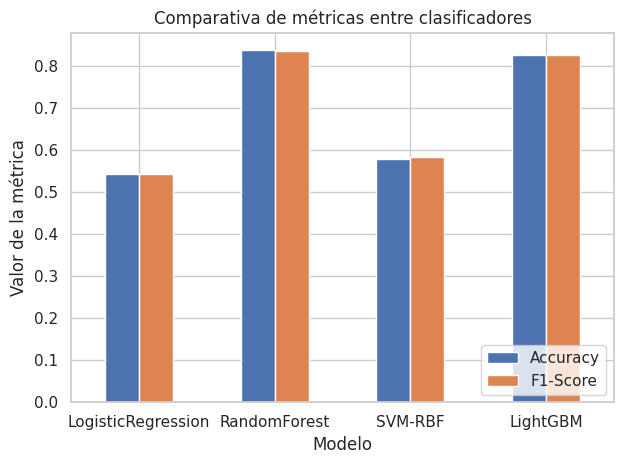

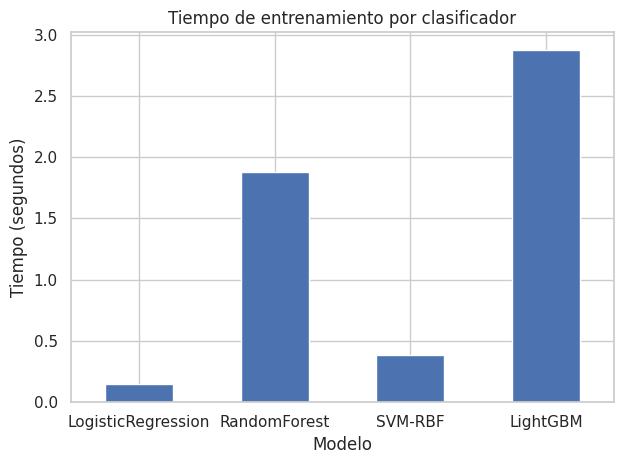

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline as SkPipeline

results = []

for name, model in plot_models.items():
    print("\n==========================")
    print(f"   Modelo: {name}")
    print("==========================")

    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    train_time = end - start
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Tiempo de entrenamiento: {train_time:.3f} s")

    results.append({
        "model": name,
        "accuracy": acc,
        "f1": f1,
        "train_time": train_time,
    })

df_results = pd.DataFrame(results)
df_results

metrics_df = df_results.set_index("model")[["accuracy", "f1"]]

ax = metrics_df.plot(
    kind="bar",
    rot=0,
)

plt.title("Comparativa de métricas entre clasificadores")
plt.ylabel("Valor de la métrica")
plt.xlabel("Modelo")
plt.legend(["Accuracy", "F1-Score"], loc="lower right")
plt.tight_layout()
plt.show()

time_df = df_results.set_index("model")["train_time"]

ax = time_df.plot(
    kind="bar",
    rot=0,
)

plt.title("Tiempo de entrenamiento por clasificador")
plt.ylabel("Tiempo (segundos)")
plt.xlabel("Modelo")
plt.tight_layout()
plt.show()
